In [3]:
%reload_ext autoreload
%autoreload 2
from alignment.alignment import Alignment
import numpy as np
import pandas as pd
from utils.path import WildcardPath
from alignment.ensemble import Ensemble
from alignment.dataset import Dataset
import matplotlib.pyplot as plt
import seaborn as sn
from features.encoding import gapped_index_mapping
from utils.general import map_ungapped_to_gapped
from features.multi import confusion_score
from utils.enums import PositionalEncodingEnum, AlignerEnum
import pymsaviz
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
import plotly.express as px


DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

BENCHMARKS = ["treebase_testing", "balibase3/RV11", "balibase3/RV12"]
INPUT_DIR = DATA_DIR / "input" / "{benchmark}"
OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"

DATASET_DIR = OUTPUT_DIR / "{dataset}"

MUSCLE5_DIR = DATASET_DIR / "Muscle5"

muscle_msas = []
benchmark = BENCHMARKS[2]
# dataset_name = OUTPUT_DIR.format(benchmark=benchmark).listdir(dirs_only=True)[0]
# dataset_name = "20413_0.phy"
dataset_name = "BB12036.msf"
dataset_dir = DATASET_DIR.format(benchmark=benchmark, dataset=dataset_name)
dataset = Dataset(
    dataset_dir
    / "sequences.fasta"
)
ensemble = Ensemble.from_efa(AlignerEnum.MUSCLE5.path, dataset_dir / "all_tools.efa", dataset=dataset)
# for idx in range(2):
#     for prefix in ["none", "abc", "acb", "bca"]:
#         msa_file = (
#             MUSCLE5_DIR.format(benchmark=benchmark, dataset=dataset_name)
#             / f"{prefix}.{idx}.msa.fasta"
#         )
#         muscle_msas.append(Alignment(msa_file))

# ensemble = Ensemble(list(muscle_msas), dataset=dataset)


print(len(ensemble.ensemble))
print(len(dataset.sequences))
print(len(ensemble.ensemble[0].msa[0]))

48
7
238


100%|██████████| 7/7 [00:00<00:00, 404.22it/s]


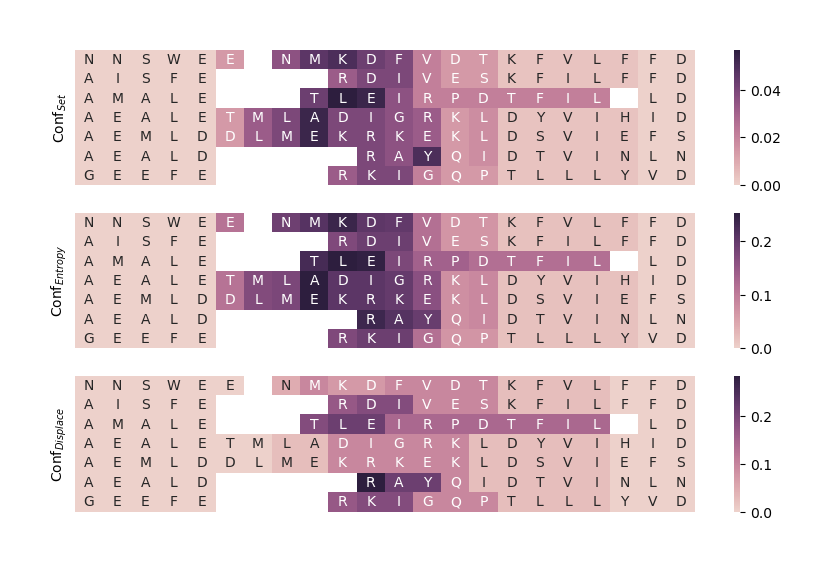

In [4]:
from utils.enums import _CONFUSION_ENUMS

score_dfs = []
char_dfs = []
for method in _CONFUSION_ENUMS:
    confusion_scores = confusion_score(
        ensemble,
        PositionalEncodingEnum.POSITION,
        normalize=True,
        method=method,
        verbose=True,
    )

    msa_idx = np.argmax([len(alignment.msa[0]) for alignment in ensemble.ensemble])
    A = np.array(ensemble.ensemble[msa_idx].msa)
    Q = gapped_index_mapping(A, dtype=np.int32)
    A_score = map_ungapped_to_gapped(confusion_scores, Q, gap_value=np.nan)
    score_dfs.append(A_score[:, 108:130])
    char_dfs.append(A[:, 108:130])

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
# fig.tight_layout()
names = ["Set", "Entropy", "Displace"]
for name, score_df, char_df, ax in zip(names, score_dfs, char_dfs, axes):
    # score_df[np.isnan(score_df)] =
    sn.heatmap(
        score_df,
        annot=char_df,
        fmt="",
        cmap=sn.cubehelix_palette(as_cmap=True),
        ax=ax,
    )
    ax.set_ylabel(r"$\text{Conf}_{" + name + r"}$")
    ax.set_xticks(ticks=[], labels=[])
    ax.set_yticks(ticks=[], labels=[])
# fig.savefig(RESULT_DIR / "balibase3" / f"confusion_example_msa.svg")

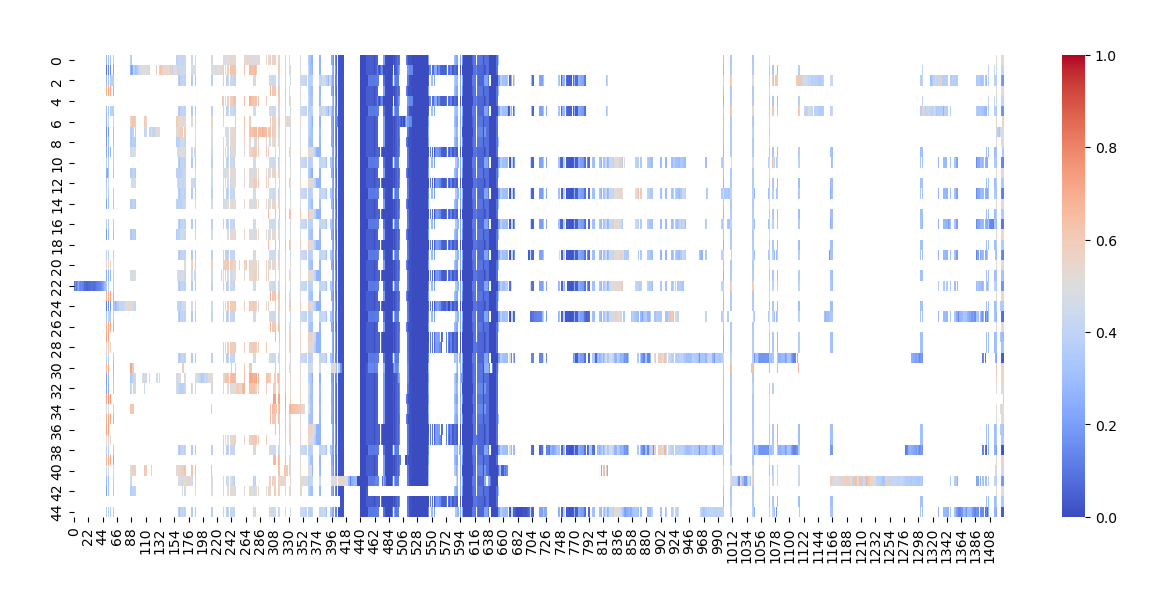

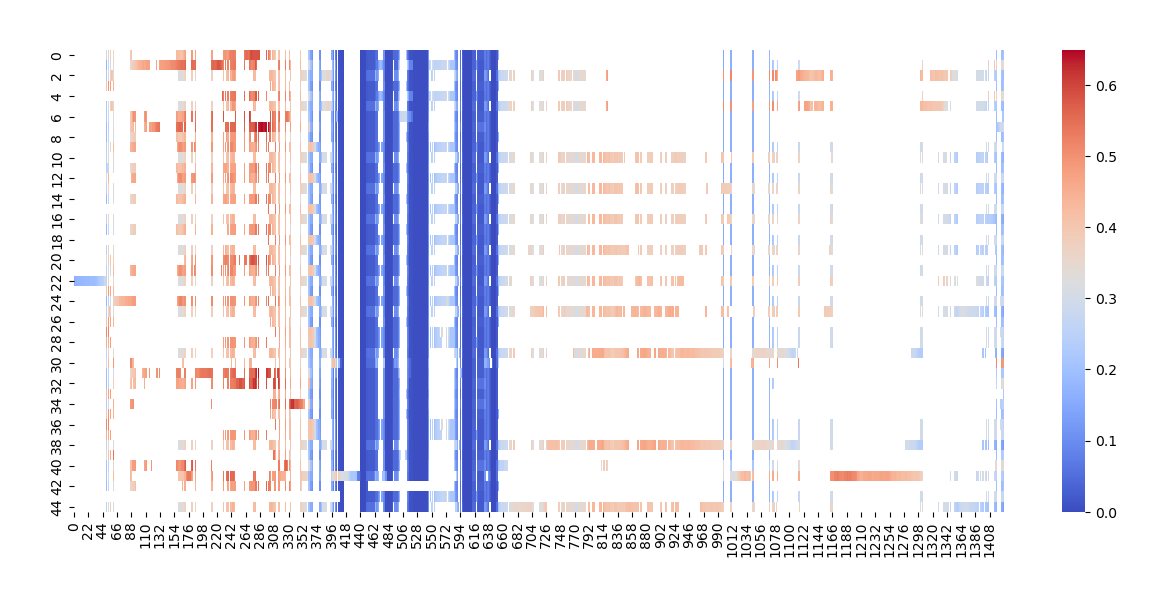

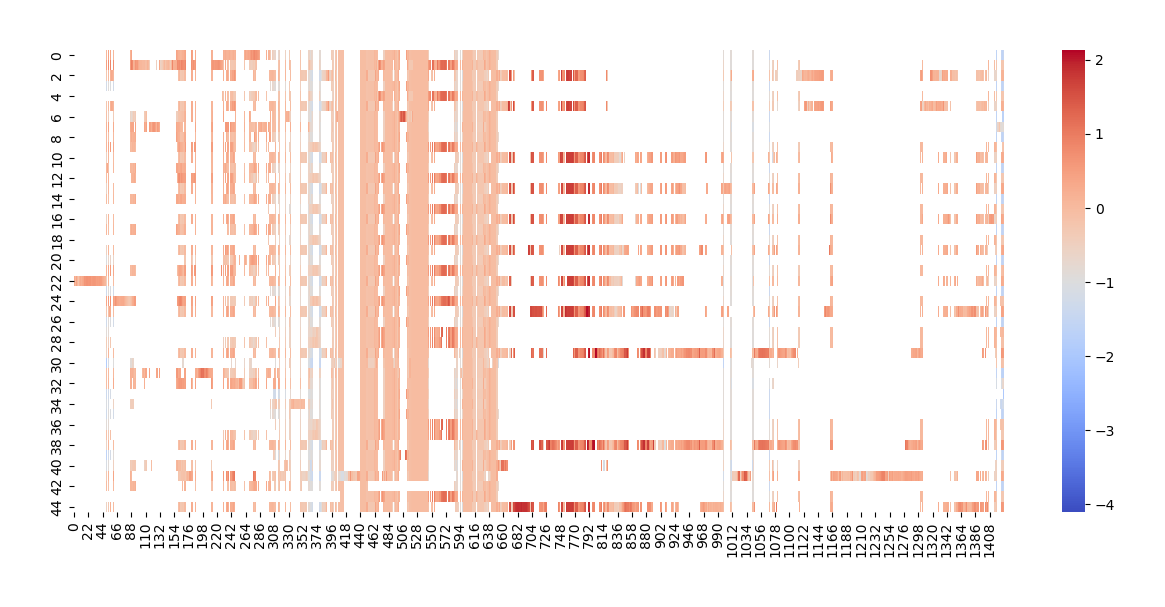

In [62]:
# Plot
msa_idx = np.argmax([len(alignment.msa[0]) for alignment in ensemble.ensemble])
A = np.array(ensemble.ensemble[msa_idx].msa)
Q = gapped_index_mapping(A, dtype=np.int32)
conf_set = confusion_score(
    ensemble, PositionalEncodingEnum.POSITION, method="confusion_displacement"
)
# print([np.isnan(row).any() for row in conf_set])
A_score = map_ungapped_to_gapped(conf_set, Q, gap_value=np.nan)
fig, ax = plt.subplots(figsize=(15, 6))
sn.heatmap(A_score, ax=ax, cmap=sn.color_palette("coolwarm", as_cmap=True))
plt.show()

conf_entropy = confusion_score(
    ensemble,
    PositionalEncodingEnum.POSITION,
    method="confusion_entropy",
)
A_score = map_ungapped_to_gapped(conf_entropy, Q, gap_value=np.nan)
fig, ax = plt.subplots(figsize=(15, 6))
sn.heatmap(A_score, ax=ax, cmap=sn.color_palette("coolwarm", as_cmap=True))
plt.show()

mean_set = np.mean(np.concatenate(conf_set))
max_set = np.max(np.concatenate(conf_set))
std_set = np.std(np.concatenate(conf_set))
mean_entropy = np.mean(np.concatenate(conf_entropy))
max_entropy = np.max(np.concatenate(conf_entropy))
std_entropy = np.std(np.concatenate(conf_entropy))

conf_set = [(seq - mean_set) / std_set for seq in conf_set]
conf_entropy = [(seq - mean_entropy) / std_entropy for seq in conf_entropy]
# conf_set = [seq / max_set for seq in conf_set]
# conf_entropy = [seq / max_entropy for seq in conf_entropy]
conf_delta = [
    seq_entropy - seq_set for seq_set, seq_entropy in zip(conf_set, conf_entropy)
]
A_score = map_ungapped_to_gapped(conf_delta, Q, gap_value=np.nan)
fig, ax = plt.subplots(figsize=(15, 6))
sn.heatmap(A_score, ax=ax, cmap=sn.color_palette("coolwarm", as_cmap=True))
plt.show()

Total mean: 0.10165843759395018
Total mean: 0.01199216805886714


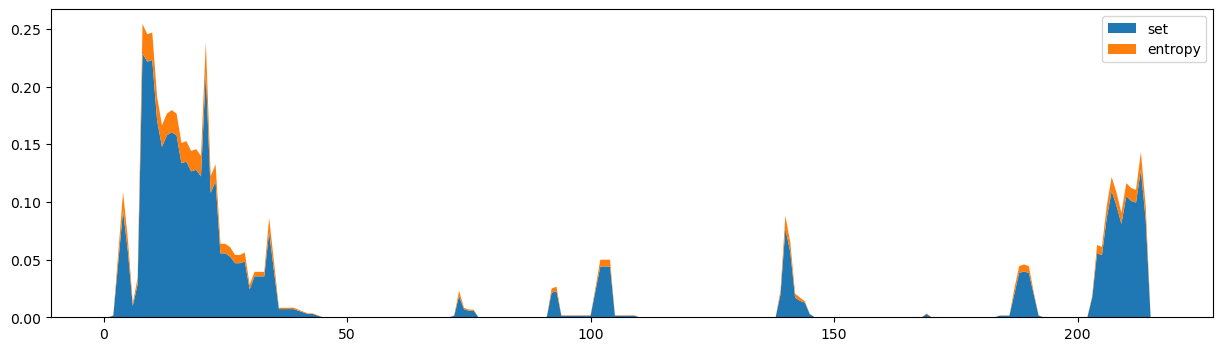

In [3]:
%autoreload 2
from features.multi import confusion_score
from utils.enums import PositionalEncodingEnum
import matplotlib.pyplot as plt

counts = Ensemble(ensemble.ensemble, dataset=dataset)
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
len_seq = 0
scores = {}
for method in ["set", "entropy"]:
    confusion_scores = confusion_score(counts, PositionalEncodingEnum.POSITION, method=method)
    scores[method] = confusion_scores[3]
    len_seq = len(confusion_scores[3])
    print("Total mean:", np.concatenate(confusion_scores).mean())

fig = plt.stackplot(
    np.arange(len_seq),
    scores.values(),
    labels=scores.keys(),
)
plt.legend()